In [1]:
from IPython.core.display import HTML
HTML(r"""
<style>
    .output-plaintext, .output-stream, .output {
        font-family: Courier; # Any monospaced font should work
        line-height: 1.3 !important;
        font-size: 14px !important;
    }
</style>
""")

In [2]:
import matplotlib.pyplot as plt
import game
from math import factorial as fac
import seaborn as sns
import agent

%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# Basic math analysis for Hoot Owl Hoot
## Number of turns in a lost game
A game is lost when the sun token has moved 13 spaces.  This can only happen after at least 13 cards have been played.


### What is the probability that a player starts the game with at least one sun card?
Since the turn order is random, this probability is the same for all players.

$$
\begin{align*}

p\left(start\ with\ at\ least\ one\ sun\right) &= 1-p\left(start\ with\ zero\ suns\right) \\

&= 1 - \left( \frac{36}{50}*\frac{35}{49}*\frac{34}{48} \right) \\
&= 0.6357
\end{align*}
$$

In [3]:
# Probability of the first hand having a sun on the first turn
p = 1 - (fac(36)/fac(3)/fac(36-3)) / (fac(50)/fac(3)/fac(50-3))
print(f'The probability of the first hand being dealt at leat one sun is {p:.4f}')

The probability of the first hand being dealt at leat one sun is 0.6357


In [4]:
# Deal 100,000 games and count the number of times the first hand contains at least one sun
n_games = 100_000
count = 0
for _ in range(n_games):
    g = game.Game()
    if game.SUN in g.hands[0]:
        count += 1

print(f'In {count / n_games:.2%} of the {n_games:,} games, the first hand started with at least one sun.')

In 63.51% of the 100,000 games, the first hand started with at least one sun.


## What is the expected position within the deck of the 13th sun card?
```
<---------------------------------k---------------->
       ^                          ^           ^  
       12 suns                    13th sun    1 sun
```

The position of the 13th sun has 12 suns before it and one sun after it.  The number of possible ways to achieve a configuration like this is the number of ways to configure 12 suns within $(k-1)$ positions multiplied by the number of positions that the last sun can be in, which is $(50-k)$.

$$ N_{specific\ permutations} = \binom{k-1}{12} \left( 50-k \right) $$

And the total number of ways to distribute 14 sun cards within 50 cards is calculated using a binomial coefficient.

$$ N_{total\ permutations} = \binom{50}{14} $$

So the probability that the 13th sun is in position $k$ is the ratio of the two expressions above.

$$ p(k) = \frac{\binom{k-1}{12} \left( 50-k \right)}{\binom{50}{14}} $$


In [5]:
# Calculate the probability density function
def binom(n, k):
    return fac(n) / fac(k) / fac(n-k)

def p(k):
    return binom(k-1, 12) * (50-k) / binom(50, 14)

x = []
y = []
for k in range(13,50):
    x.append(k)
    y.append(p(k))

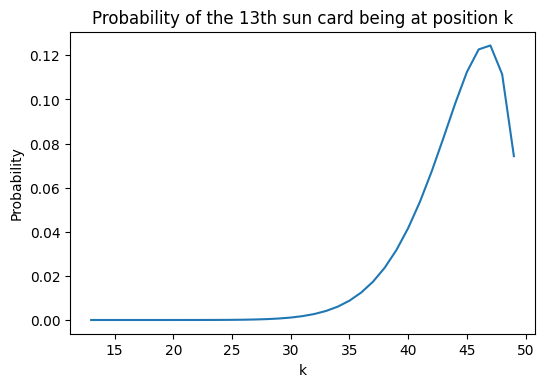

In [6]:
# Plot the probability density function
pdf = sns.lineplot(x=x, y=y)
_ = pdf.set(
    title='Probability of the 13th sun card being at position k',
    xlabel='k',
    ylabel='Probability'
)


And the expected position of the 13th sun is:

$$
\begin{align*}

E[k_{13}] &= \sum_{k=13}^{49}p(k)k \\

&= \sum_{k=13}^{49} \left[ \frac{\binom{k-1}{12} \left( 50-k \right)}{\binom{50}{14}} k \right] \\
&= \sum_{k=13}^{49} \left[ \frac{k(k-1)!(50-k)} {(k-13)!} \frac{14!*36!}{12!*50!} \right] \\
&= 44.2

\end{align*}
$$

In [7]:
# Set up 100,000 decks and find the average position of the 13th sun
n_games = 100_000
sum = 0

for _ in range(n_games):
    d = game.Deck()
    d.shuffle()
    sum += d.position_of_nth_card(game.SUN, 13)

avg = sum / n_games
print(f'The average position of the 13th sun is {avg + 1:.3f}')

The average position of the 13th sun is 44.200


This result confirms that a single player game is expected to have 44.2 cards dealt and have 42.2 moves.

## Average number of cards played
Since each player begins the game with an extra two cards in addition to the initial "draw", the number of cards that need to be drawn before the 13th sun is reached is two less for each player in the game.

$$
E[N_{cards\_played}] = \sum_{k=13}^{49} \left[ \frac{k(k-1)!(50-k)} {(k-13)!} \frac{14!*36!}{12!*50!} \right] - 2 N_{players}
$$

## Average number of cards dealt
The number of cards dealt is directly related to the number of cards played and the number of players.  There are two additional cards dealt per player due to the starting hand.  Since the game ends with one player playing one of their three cards, they end with only two cards and a replacement card is not drawn.  Therefore, one less card is dealt.

$$
N_{cards\_dealt} = N_{cards\_played} + 3 N_{players} - 1
$$

| $N_{players}$ | $E[N_{cards\_played}]$ | $E[N_{cards\_dealt}]$ |
| --- | --- | --- |
| 1 | 42.2 | 44.2 |
| 2 | 40.2 | 45.2 |
| 3 | 38.2 | 46.2 |
| 4 | 36.2 | 47.2 |


In [8]:
# Find the average length of a one player game
n_games = 1_000_000

for N_players in range(1,5):
    sum = 0

    for _ in range(n_games):
        a = agent.Agent(n_hands=N_players)
        a.play_game()
        sum += len(a.game.deck.cards)

    avg_cards_remaining = sum / n_games
    avg_cards_played = 50 - avg_cards_remaining - 3 * N_players + 1
    avg_cards_dealt = 50 - avg_cards_remaining

    print(f'The average cards played in a {N_players} player game using random moves is {avg_cards_played:.3f}.')
    print(f'The average number of cards dealt in a {N_players} player game using random moves is {avg_cards_dealt:.3f}')

The average cards played in a 1 player game using random moves is 42.197.
The average number of cards dealt in a 1 player game using random moves is 44.197
The average cards played in a 2 player game using random moves is 40.198.
The average number of cards dealt in a 2 player game using random moves is 45.198
The average cards played in a 3 player game using random moves is 38.128.
The average number of cards dealt in a 3 player game using random moves is 46.128
The average cards played in a 4 player game using random moves is 35.937.
The average number of cards dealt in a 4 player game using random moves is 46.937


The simulations above do not seem to support the calculated expectations for three and four player games.